# Potential vorticity
Plot vertical piece of Ertel potential vorticity, 
$N^2(f+\zeta)$

In [1]:
%matplotlib inline
import pandas as pd
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from dask.distributed import Client, progress


import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/surface_pv"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
client = Client("tcp://10.6.121.72:8786")
session = cc.database.create_session()
client

<Client: 'tcp://10.6.121.72:8786' processes=1 threads=28, memory=125.20 GiB>

cc.start_cluster()

from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
clim_years = 20  # how many years to use for model climatology

In [5]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'EAC_ACC_SouthPacific': [140-360,240-360,-65,-20], 
#               'EAC_ACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [6]:
# load model speed climatologies and snapshots
speeds = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
for ekey in speeds.keys():
     if ekey=='01deg': # for testing
        expt = speeds[ekey]['expt']
        print(ekey)

        ## Load PV from expt
        darray = cc.querying.getvar(session=session, expt=expt, variable='vert_pv')
        pvall = darray
        pvall = pvall.sel(st_ocean=slice(0,1000)).mean('st_ocean')

        tend = pvall['time'].data[-1]  # final time in model data
        tstart = pvall['time'].data[0]  # first time in model data
        tclimend = tend  # end of climatology  --  NB: type should be numpy.datetime64 but might be <class 'datetime.datetime'>
        if isinstance(tclimend, np.datetime64):
            tclimstart = pd.to_datetime(tclimend) - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology
            tclimstart = tclimstart.to_datetime64()  # match to time type
        else:
            tclimstart = tclimend - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology

#         pv = pvall.isel(st_ocean=0).sel(time=slice(tclimstart,tclimend)).mean('time')
#         pv_snap = pvall.isel(st_ocean=0).isel(time=-1)
        pv = pvall.sel(time=slice(tclimstart,tclimend)).mean('time')
        pv_snap = pvall.isel(time=-1)


        speeds[ekey]['pv'] = pv
        speeds[ekey]['pv_snap'] = pv_snap
        speeds[ekey]['tend'] = tend
        speeds[ekey]['tstart'] = tstart
        speeds[ekey]['tclimend'] = tclimend
        speeds[ekey]['tclimstart'] = tclimstart
        del(pvall)

01deg


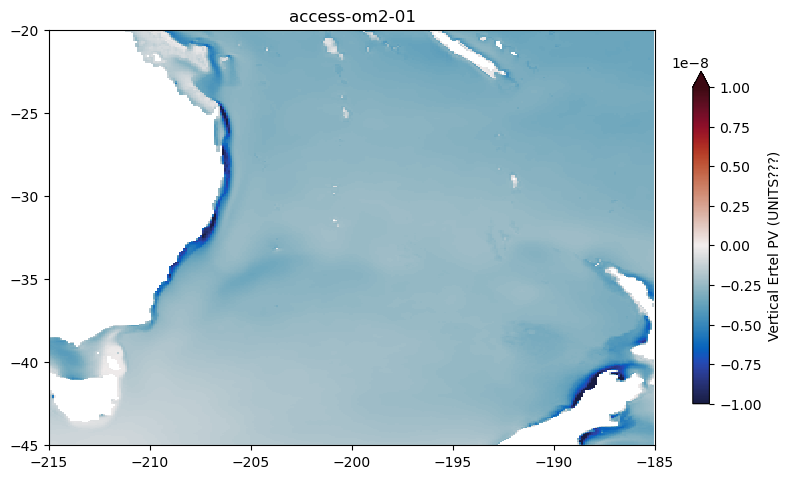

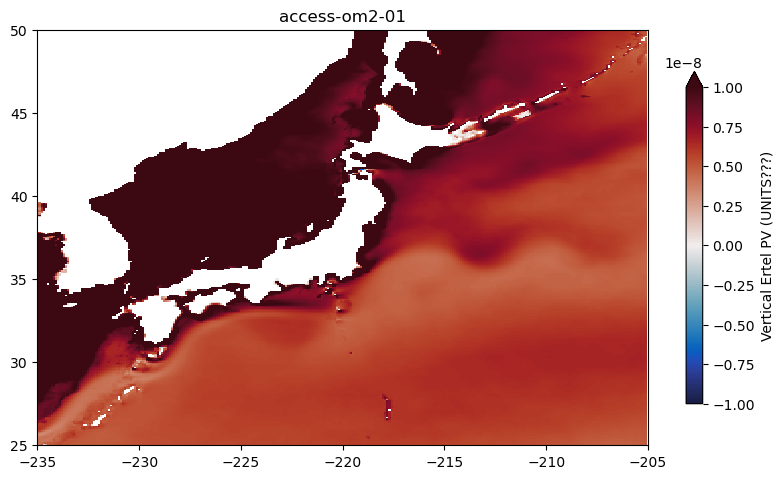

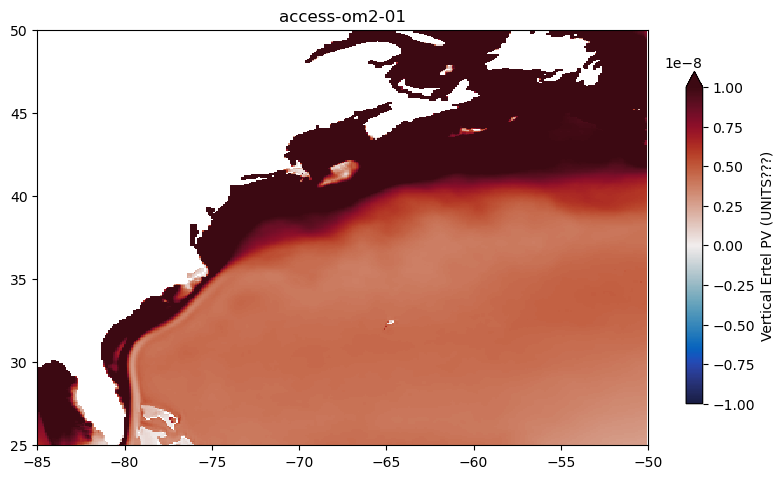

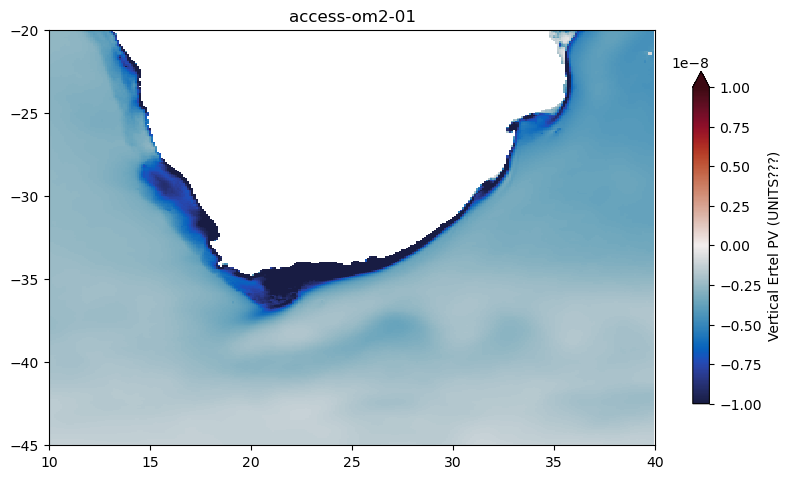

In [8]:
# plot obs and all model mean speeds in each location
vmax = 1e-8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    for i, ekey in enumerate(speeds.keys()):
        if ekey=='01deg': # for testing
            ax = fig.add_subplot(ncols, nrows, i+2)
            speed = speeds[ekey]['pv'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(speed.xt_ocean, speed.yt_ocean, speed[:-1,:-1], 
                                shading='flat', cmap=cm.cm.balance, vmin=-vmax, vmax=vmax)
            plt.title(speeds[ekey]['model'], fontsize=12)
            plt.xlim(loc[0],loc[1])
            plt.ylim(loc[2],loc[3])
            fig.colorbar(cax,shrink=0.8,label='Vertical Ertel PV (UNITS???)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

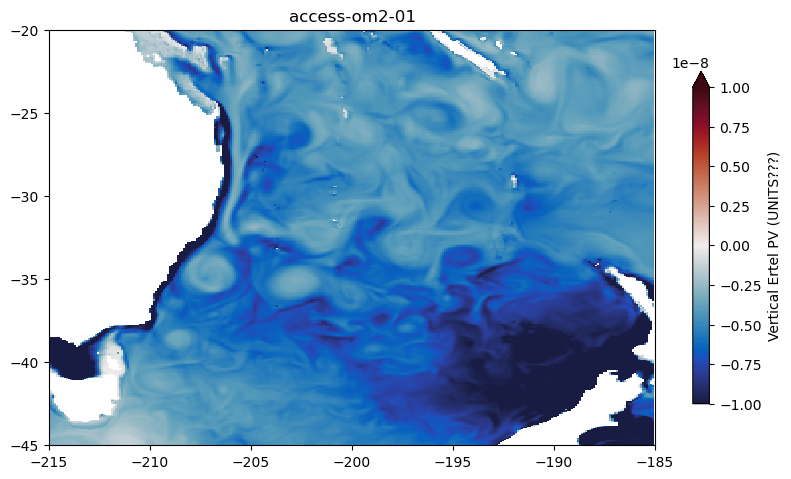

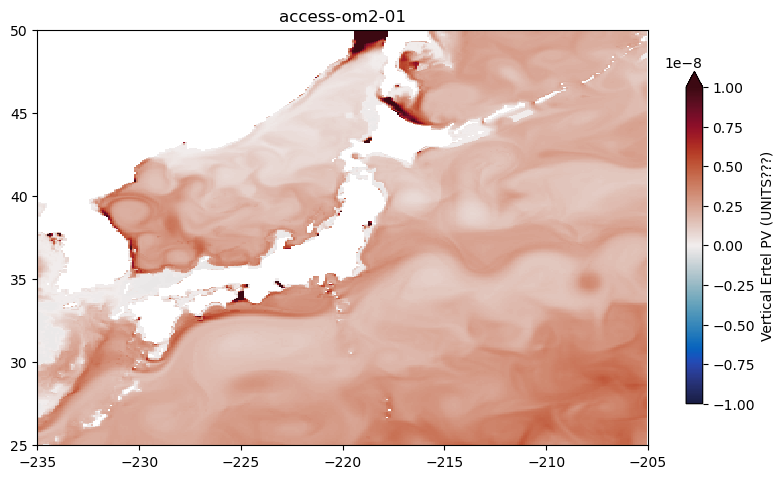

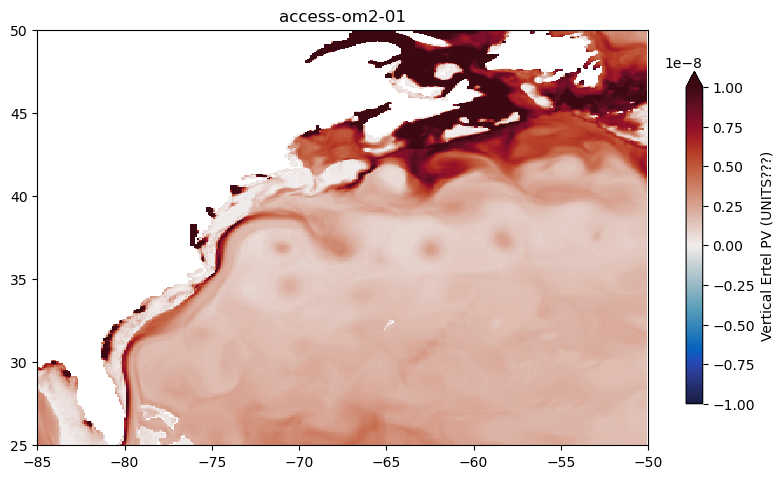

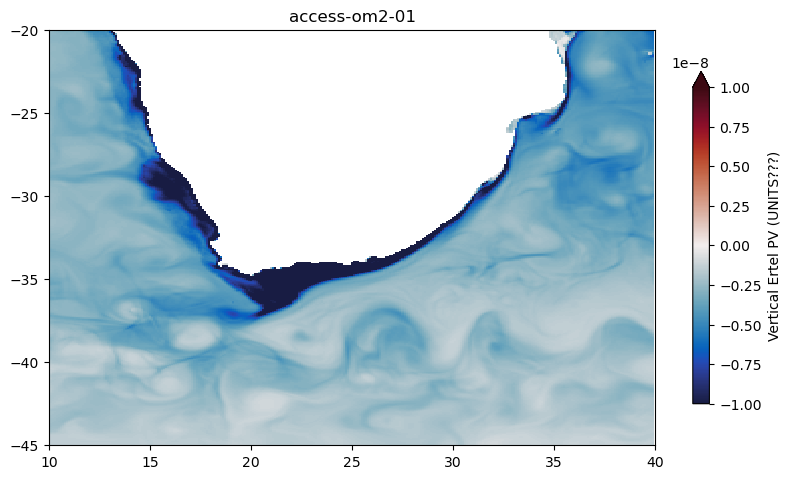

In [10]:
# plot obs and all model mean speeds in each location
vmax = 1e-8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    for i, ekey in enumerate(speeds.keys()):
        if ekey=='01deg': # for testing
            ax = fig.add_subplot(ncols, nrows, i+2)
            speed = speeds[ekey]['pv_snap'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(speed.xt_ocean, speed.yt_ocean, speed[:-1,:-1], 
                                shading='flat', cmap=cm.cm.balance, vmin=-vmax, vmax=vmax)
            plt.title(speeds[ekey]['model'], fontsize=12)
            plt.xlim(loc[0],loc[1])
            plt.ylim(loc[2],loc[3])
            fig.colorbar(cax,shrink=0.8,label='Vertical Ertel PV (UNITS???)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

The cell that was previously here has been removed because it is effectivly the same as surface_current.ipynb